# Tutorial: Modeling M&M Colors with the Multinomial Distribution and a Dirichlet Prior in Pyro

##  Learning Objectives
By the end of this tutorial, students will:

* Understand the multinomial distribution for modeling categorical counts.
* Use a Dirichlet prior to encode beliefs about the color proportions.
* Compute the analytic posterior using conjugate prior theory.
* Write a simulator for use with simulation-based inference
* Use simulation-based inference with Neural Posterior Estimation to obtain unbiased samples from the posterior, even when squirrels mess with your colour distributions!

## 1. Scenario

You're handed a pack of M&Ms and asked to estimate the proportion of each color in the population of all M&Ms. This is an extension to the exercise we did earlier this week, where we just looked at blue M&Ms versus the rest.

## Imports

In [15]:
# plotting
import matplotlib.pyplot as plt
import seaborn as sns 

# Basic numerical and plotting tools
import numpy as np
import pandas as pd

# PyTorch and Pyro for probabilistic programming
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS

# ArviZ for visualization and diagnostics of posterior samples
import arviz as az

# SBI package for simulation-based inference
from sbi.analysis import pairplot
from sbi.inference import NPE
from sbi.utils import BoxUniform
from sbi.utils.user_input_checks import process_prior
import sbi

## 2. Collect Some Data

Example data from counting M&M colors:


In [2]:
colors = [f"red", f"green", f"blue",f"yellow", f"orange", f"brown"]

## ADD YOUR OBSERVED COUNTS BELOW
red = 400
green = 200
blue = 600
yellow = 900
orange = 400
brown = 300

observed_counts = torch.tensor([red, green, blue, yellow, orange, brown])
total_count = observed_counts.sum()

## 3. Model Assumptions

We assume that the counts for different colours follow a [multinomial distribution](https://en.wikipedia.org/wiki/Multinomial_distribution):
$$
x \sim \mathrm{Multinomial}(n, \theta)
$$

The multinomial distribution is the multi-dimensional extension to the binomial distribution. Where before we had two possible outcomes (blue and not blue), we now have $k$ outcomes. Here, $\theta = (q_1, ..., q_k)$ is now a vector describing the intrinsic fraction of each colour, for all colours, so it's a vector of length $k$. 
The multinomial distribution is defined as:

$$ 
p(x_1, ..., x_k | q_1, ..., q_k, n) = \frac{n!}{x_1! ... x_k!}q_1^{x_1} ... q_k^{x_k}
$$ 

If we want to compute our probabilities analytically, we can use the conjugate prior for the multinomial distribution, which is a [Dirichlet distribution](https://en.wikipedia.org/wiki/Dirichlet_distribution). Conveniently, the Dirichlet distribution is the multivariate version of the beta-distribution, which we met earlier this week!

$$
\theta \sim \mathrm{Dirichlet}(\alpha)
$$

The Dirichlet distribution has parameters $\alpha$, and just like with the beta-distribution, we need to pick values for these. Here, we choose a non-informative prior, for which $\alpha=1$

In [3]:
alpha_prior = torch.ones(len(colors))  # Non-informative prior

# 4. Analytic Posterior 

For the analytical case, we know (or can calculate, you're encouraged to try this at home!) that the resulting posterior of the multinomial likelihood and Dirichlet prior will also be a Dirichlet distribution:

$$
\theta | x \sim \mathrm{Dirichlet}(\alpha + x)
$$ 

Here, $x$ is the vector of measured M&M counts. 

### Compute Posterior Parameters and Draw Samples

Now let's compute the posterior. Use `torch.distributions.Dirichlet()` to sample 1000 times from the Dirichlet posterior:

In [4]:
# Compute posterior parameters, using the prior we defined above and the observed M&M counts
alpha_posterior = alpha_prior + observed_counts

# Draw samples from the posterior:
posterior_analytic_samples = torch.distributions.Dirichlet(alpha_posterior).sample((1000,))

### Visualize the Analytic Posterior

What do our posteriors look like?

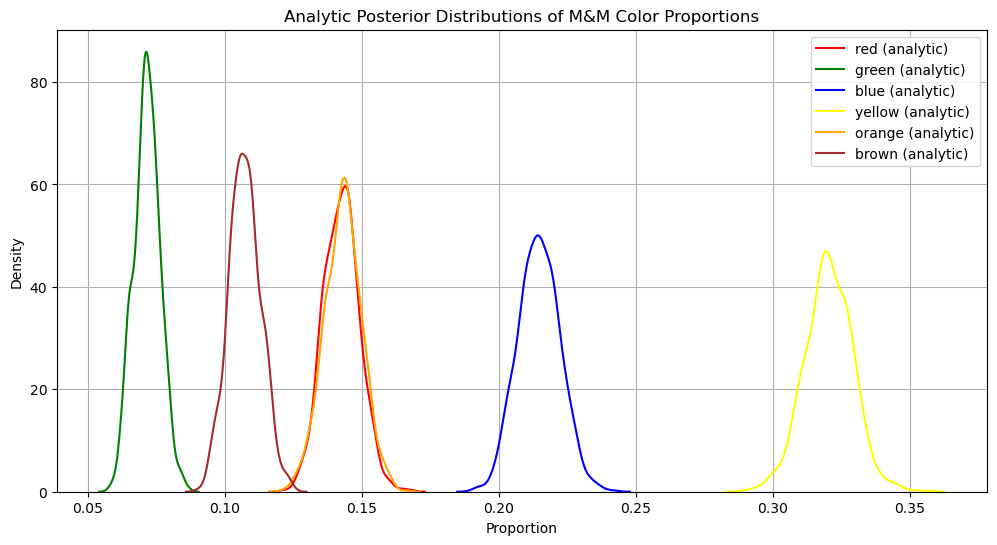

In [5]:
plt.figure(figsize=(12, 6))
for i, color in enumerate(colors):
    sns.kdeplot(posterior_analytic_samples[:, i], label=f"{color} (analytic)", color=color)
plt.title("Analytic Posterior Distributions of M&M Color Proportions")
plt.xlabel("Proportion")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

# Part 2: Modeling M&M Selection Bias with Simulation-Based Inference (SBI)

##  Goal
Model the true M&M color proportions when the observed data is biased due to preferential removal of orange and brown M&Ms (due to squirrels in the factory!).


##  1. Simulate Biased Observations

We'll start with known "true" color proportions and simulate M&M draws. Then, we'll bias the data by removing a fraction of orange and brown M&Ms.



In [6]:
torch.manual_seed(0)

num_colors = len(colors)
true_probs = torch.tensor([0.25, 0.05, 0.20, 0.15, 0.18, 0.17])  # ground truth

# Simulate true counts
total_mms = 200
true_counts = torch.distributions.Multinomial(total_mms, probs=true_probs).sample()

# Simulate bias: remove 50% of orange and 80% of brown M&Ms
bias = torch.ones(num_colors)
bias[colors.index("orange")] = 0.5
bias[colors.index("brown")] = 0.2

# true parameters of the model: the true probabilities for each color, and the two biases
true_theta_and_bias = torch.hstack([true_probs, torch.tensor([bias[colors.index("orange")], bias[colors.index("brown")]])])

# number of model parameters
nparams = len(true_theta_and_bias)

biased_counts = torch.floor(true_counts * bias).int()

print("True counts:    ", true_counts.int().tolist())
print("Biased counts:  ", biased_counts.tolist())

True counts:     [51, 11, 37, 32, 41, 28]
Biased counts:   [51, 11, 37, 32, 20, 5]


## 2. Problem: Can't use Multinomial Directly

We no longer have an analytic posterior. What happens if we compute the posterior of the biased counts? Let's find out:

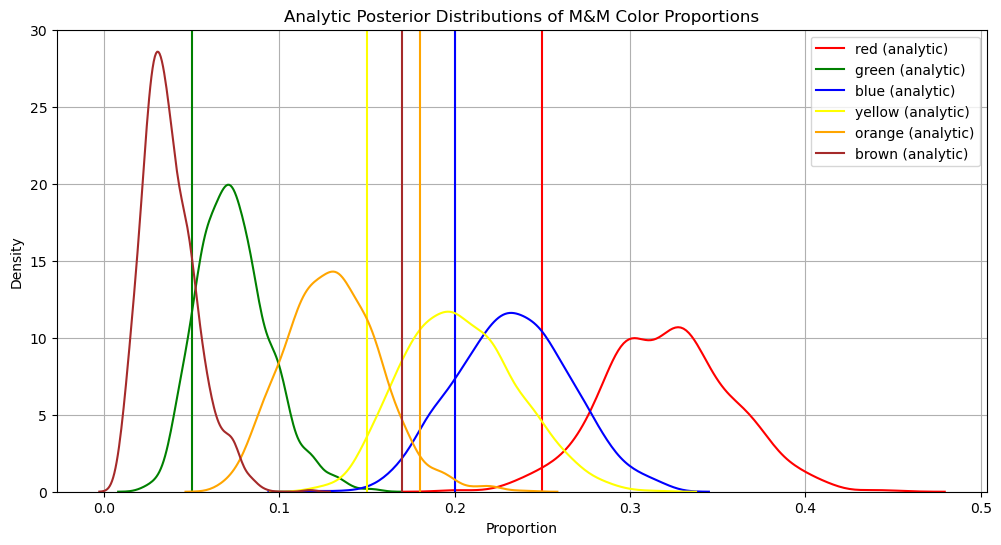

In [7]:
alpha_posterior_new = alpha_prior + biased_counts

# Draw samples from the posterior:
posterior_analytic_samples = torch.distributions.Dirichlet(alpha_posterior_new).sample((1000,))

plt.figure(figsize=(12, 6))
for i, color in enumerate(colors):
    sns.kdeplot(posterior_analytic_samples[:, i], label=f"{color} (analytic)", color=color)
    plt.axvline(true_probs[i], color=color)
plt.title("Analytic Posterior Distributions of M&M Color Proportions")
plt.xlabel("Proportion")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

**Question**: Why isn't it just that the brown and orange posteriors are off? Can you think about why *all* of the posteriors are off?


**Solution**: All of these look wrong! This is because when you underestimate the posterior probability for one color, you immediately need to *overestimate* the probability for another. This is what you see here: the posteriors for brown and orange underestimate the true fraction of M&Ms of that colour, as we would expect, since we've removed some of them from the processing line. In return, the posteriors for yellow, blue and red are *overestimated* to compensate.

## Using Simulation-Based Inference to Infer the Correct Proportions

How can we 


In [8]:
samples = torch.distributions.Multinomial(200, probs=true_probs).sample()
print(samples)

tensor([48., 17., 41., 32., 33., 29.])


In [9]:
# Simulation model: maps theta to biased observed counts
def mm_simulator(theta_and_bias):
    """
    Simulate draws from a bag of M&Ms, where the brown and orange M&M counts 
    are biased. 

    Parameters
    ----------
    theta_and_bias : torch.tensor
        A tensor with 8 elements. The first six are the input color distribution,
        the last two contain the biases for the brown and orange colours.
        `theta_and_bias` can be a single set of parameters, or a tensor of multiple 
        parameter sets. 

    Returns
    -------
    samples_biased : torch.tensor
        The M&M counts for all six colours
    """
    total_mms = 200
    num_colors = 6
    # if only one set of parameters, reshape such that the first dimension
    # is the batch dimension of size 1
    if theta_and_bias.dim() == 1:
        theta_and_bias = theta_and_bias.reshape((1, len(theta_and_bias)))

    batch_size = theta_and_bias.shape[0]
    theta, bias = theta_and_bias.split([6,2], dim=1)
    bias_all = torch.ones(batch_size, 6)
    bias_all[:,4] = bias[:,0]
    bias_all[:,5] = bias[:,1]
    samples = torch.distributions.Multinomial(total_mms, probs=theta).sample()
    samples_biased =  samples * bias_all  # apply bias (element-wise)
    return samples_biased.floor()

Let's try it out!

In [10]:
theta = torch.tensor([0.2, 0.3, 0.1, 0.25, 0.05, 0.1])
bias = torch.tensor([0.5, 0.2])

theta_and_bias = torch.hstack([theta, bias])

In [11]:
samples_biased = mm_simulator(theta_and_bias)
print(samples_biased)

tensor([[36., 64., 19., 45.,  6.,  4.]])


Now we can set up our inference. First, we need to define some priors. 
We will keep our Dirichlet prior for the colour distribution, and we'll define uniform priors for the two biases, between zero and one (where 1 means no M&Ms have been taken by squirrels, and 0  means all M&Ms have been taken by squirrels). 

In [12]:
from sbi.utils import MultipleIndependent

prior = MultipleIndependent(
    [
        torch.distributions.Dirichlet(alpha_prior),
        sbi.utils.torchutils.BoxUniform(torch.zeros(2), torch.ones(2))
    ],
    validate_args=False,
)


Now we need to generate training data! We will use something called *amortized inference*, where we generate all of our training data in advance. We will generate data from the whole of our prior, so that we can be sure to cover the whole parameter space we're interested in: 

In [13]:
# Generate training data
num_simulations = 5000

# sample from prior
prior_samples = prior.sample((num_simulations,))

# simulate data sets from prior samples
x_simulated_biased = mm_simulator(prior_samples)

We need to put the prior into a form that can be used by SBI. Thankfully, the package has a helper function for us:

In [16]:
prior, num_parameters, prior_returns_numpy = process_prior(prior)

Here's where we now train the normalizing flow. We'll use Neural Posterior Estimation, which uses Normalizing Flows to estimate the entire posterior. We use the standard type of normalizing flow, called a Masked Autoregressive Flow. The three lines below set up that neural network architecture and train it. The SBI package abstracts away an enormous amount of machine learning for this, but don't be fooled: knowledge of machine learning and how neural networks work is really important to understanding SBI, and especially figuring out when and how things go wrong! Don't blindly apply it!

In [20]:
# set up the Neural Posterior Estimation Object
inference = NPE(prior=prior)

# add simulations to inference object
inference = inference.append_simulations(prior_samples, x_simulated_biased)

# train the density estimator
density_estimator = inference.train()

 Neural network successfully converged after 229 epochs.

Now we can extract samples for our given observations, and plot our posteriors. Note that for interal consistency reasons, the estimator expects to get the data as a column tensor, rather than a row tensor. So you want it's shape to be `(1, num_colors)`, rather than `(num_colors, 1)` as it is saved. This is the reason for the `reshape` operation below.

In [21]:
samples = density_estimator.sample((1000,), condition=biased_counts.reshape((1,num_colors))).detach()

# remove batch dimension
samples = samples.squeeze(dim=1)

labels = list(np.hstack([colors, [f"bias_orange", f"bias_brown"]], dtype=str))

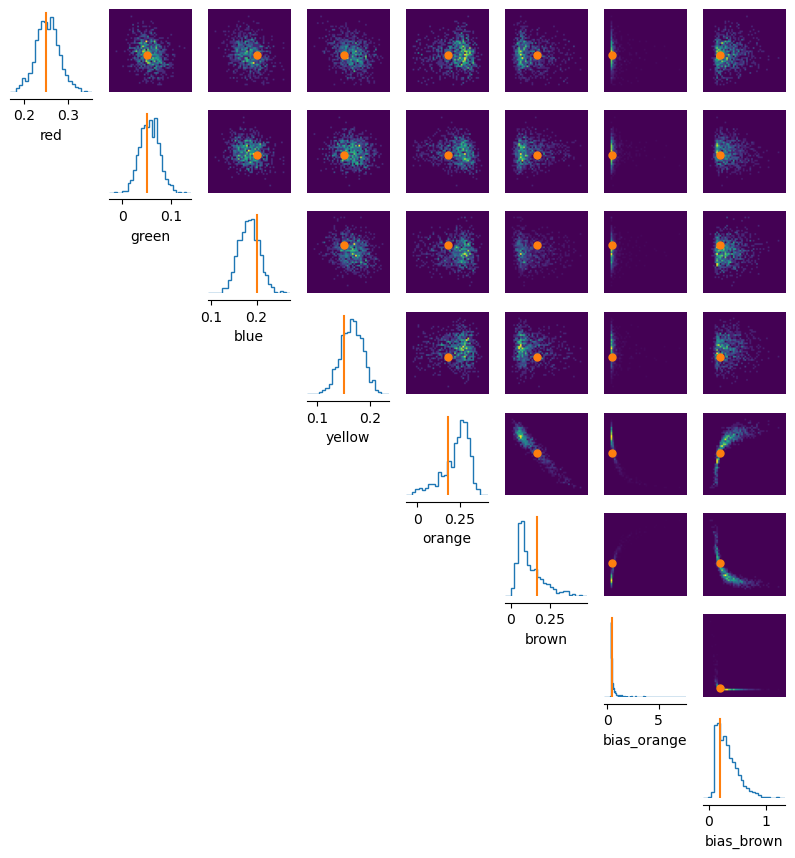

In [22]:
sbi.analysis.pairplot(samples, points=true_theta_and_bias.reshape((1, nparams)), labels=labels);

**Exercise**:
* Is our inference good? How could we tell?
* Repeat the analysis above with different numbers of training data sets: try it with ten training examples, with 100, and with 10000 (and if you can, with more). Do the posteriors change? How? How many training examples do you need to trust that the posteriors come out right?

## Validating SBI Results for Science.

One key issue with neural networks is that they're very difficult to interpret: we don't know what happens inside of them, and so it's hard to understand *why* a neural network produces a certain output. This, in turn, makes it hard to understand whether the posteriors we get out are robust and trustworthy. 

This then makes it especially important to validate our SBI results. Below, I'll give you some suggestions and exercises that you can use to validate SBI results in practice.

### Step 1: Pick a toy problem where you *can* compute a likelihood

Before you go full SBI on your problem, you might want to consider exploring a problem where you *can* compute a likelihood, and compare the SBI results to the results from the posteriors you get with a likelihood. 

This is especially important if your problem requires an embedding net, where you need to train both a data summarizing network and the normalizing flow. This can be hard to get to work correctly, so having a problem where you can figure out what's happening is super useful. 

**Exercise**
* write a simple simulator *without* the bias, just a model that draws from the multi-nomial distribution we'd expect without squirrel infestation, and returns the draws
* train a normalizing flow with that simulator
* compute the posterior for different true values of the color distributions, and compare to the the analytical posteriors. What do you find?
* Vary the number of total M&Ms in your sample: do the results change?

**Important**: Make sure you name your simulator and density estimator differently, so that we can keep using the one above later!

### Step 2: Implement the actual simulator, then explore posterior space

Let's go back to our original simulator, and the biased samples. Train the density estimator with however many simulations you decided earlier are reasonable, then explore parameter space:

**Exercise**
* change the total number of M&Ms (you'll have to change that number in the simulator, and then resimulate training examples and retrain the density estimator each time you do this): does SBI work the same for all total numbers of M&Ms?
* generate fake data for different combinations of true parameters, and explore the posterior for each simulated data set. What happens when the biases are very large, or very small? What happens when the fractions of colours are very unequal?

### Step 3: A more formal analysis of the SBI performance

There are a bunch of different ways you can analyse the performace of a density estimator, but a popular one are probability-probability plots. These describe how often the true parameters are within a certain credible interval of the posterior. To calculate them, you need *many* simulated data sets and their corresponding posterior densities, which is why amortized SBI is often really useful in practice!

Below is a function that calculates the pp-plot for each parameter, and then plots it as a curve:

### PP Plots

In [ ]:
def compute_and_plot_pp(true_params, posterior_samples, n_bins=20, labels=None):
    """
    Compute and plot marginal PP plots for each parameter dimension.

    Parameters:
    - true_params: np.ndarray of shape (N, D) — true parameter vectors
    - posterior_samples: np.ndarray of shape (N, S, D) — samples from posteriors
    - n_bins: int — number of coverage levels (e.g., 20 for 5% increments)
    """
    N, D = true_params.shape
    assert posterior_samples.shape[:2] == (N, posterior_samples.shape[1])
    assert posterior_samples.shape[2] == D

    alphas = np.linspace(0, 1, n_bins + 1)
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    ax.plot(alphas, alphas, "--", label="Ideal")
 
    if labels is None:
        labels = [rf"$x_{d}$" for d in range(D)]

    for d in range(D):
        # Compute rank statistics per simulation for parameter d
        true_vals = true_params[:, d]
        samples_d = posterior_samples[:, :, d]

        # Sort each posterior sample set
        sorted_samples, indices = torch.sort(samples_d, axis=1)

        # Compute empirical coverage for each alpha
        coverage = []
        for alpha in alphas:
            lower_idx = ((1.0 - alpha) / 2.0 * samples_d.shape[1]).astype(int)
            upper_idx = ((1.0 + alpha) / 2.0 * samples_d.shape[1]).astype(int)
            #print(sorted_samples)
            #print(lower_idx)
            #print(upper_idx)
            lower = sorted_samples[:, lower_idx]
            upper = sorted_samples[:, np.minimum(upper_idx, samples_d.shape[1]-1)]
            covered = (true_vals >= lower) & (true_vals <= upper)
            coverage.append(torch.sum(covered)/len(lower))

        # Plot PP plot for this dimension
        ax.plot(alphas, coverage, label=labels[d], lw=2)
        ax.set_title(f"PP Plot for Parameter {d}")
        ax.set_xlabel("Nominal Credible Level")
        ax.set_ylabel("Empirical Coverage")
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()

Now we can try it out!

First run the inference 500 times, drawing from the prior:

In [34]:
nsamples = 1000
nsims = 500
ndim = 8

# sample from prior
pp_prior_samples = prior.sample((nsims,))

# simulate data sets from prior samples
pp_x_simulated_biased = mm_simulator(pp_prior_samples)

Now we can get posterior samples for all of these prior samples:

In [37]:
pp_samples.shape

torch.Size([500, 1000, 8])

In [38]:
pp_samples = torch.zeros((nsims, nsamples, ndim))
for i, px in enumerate(pp_x_simulated_biased):
    samples = density_estimator.sample((nsamples,), condition=px.reshape((1,num_colors))).detach()
    pp_samples[i,:,:] = samples.squeeze(dim=1)

Let's run it!

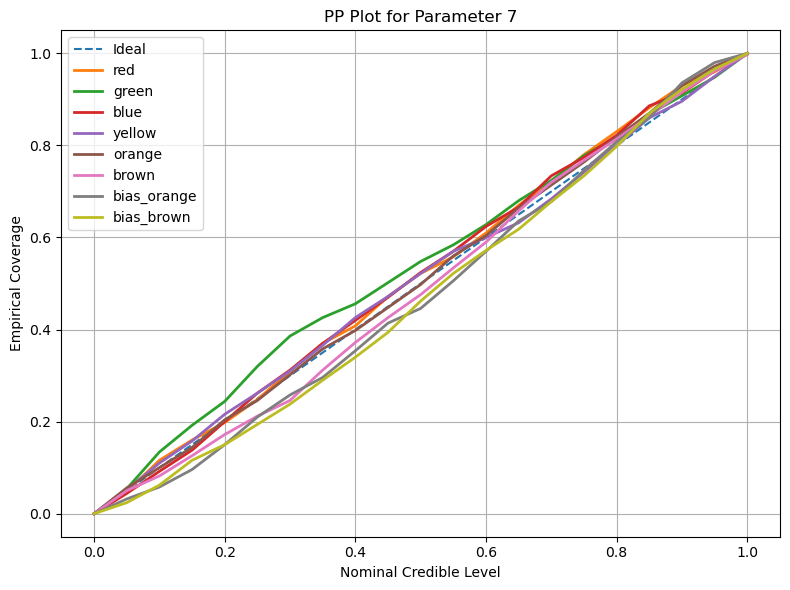

In [73]:
compute_and_plot_pp(pp_prior_samples, pp_samples, labels=labels)